In [2]:
#### IMPORTS  ####
from pathlib import Path
from typing import Tuple, List
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm
import random
import datetime
import pathlib
import pytz
import glob
import re
from google.colab import drive
from torch.autograd import Variable
import seaborn as sns
import os
import shutil
import copy
import matplotlib.dates as mdates
drive.mount('/content/drive', force_remount=True)


ModuleNotFoundError: No module named 'torch'

In [2]:
#### Definitions ####
PATH_ROOT = "drive/MyDrive/Efrat/" # Change only here the path
#PATH_ROOT = "drive/MyDrive/RonenRojasEfratMorin/Code/" # Change only here the path
PATH_DATA_FILE  = PATH_ROOT + "Data/raw_data_fixed_17532_3_22_38"
PATH_LABEL = PATH_ROOT + "Data/CWC/"
PATH_LOC  = PATH_ROOT +"Data/LatLon/{0}_lat_lon" 
PATH_DATA_CLEAN  = PATH_ROOT + "Data/IMD_Lat_Lon_reducded/"
PATH_MODEL = PATH_ROOT + "cnn_lstm/"
DISCH_FORMAT = "CWC_discharge_{0}_clean"
PATH_CATCHMENTS = PATH_ROOT + "Data/catchments.xlsx" 
FILE_FORMAT = "data_{0}_{1}"

LAT_MIN = 17.375
LAT_MAX = 22.625
LON_MIN = 73.625
LON_MAX = 82.875
GRID_DELTA = 0.25
LAT_GRID = np.arange(LAT_MIN, LAT_MAX + GRID_DELTA/2, GRID_DELTA) 
LON_GRID = np.arange(LON_MIN, LON_MAX + GRID_DELTA/2, GRID_DELTA) 
DATA_LEN = 17532
NUM_CHANNELS = 3
H_LAT = len(LAT_GRID)  
W_LON = len(LON_GRID)
DATA_START_DATE = (1967, 1, 1)
DATA_END_DATE = (2014, 12, 31)

def get_index(data, date_input):
  year, month, day= date_input
  return int(np.where(np.array(data[0] == year)*np.array(data[1] == month)*np.array(data[2] == day))[0].squeeze())


def get_geo_raw_data(lat, lon, start_date, end_date):
  # Getting data by lat lon coordinates
  data = pd.read_csv(PATH_DATA_CLEAN + FILE_FORMAT.format(lat, lon), header=None, delim_whitespace=True)
  idx_start, idx_end  = get_index(data, start_date) , get_index(data, end_date)
  x = np.array(data[3][idx_start:idx_end+1])
  x = np.concatenate([[x], [np.array(data[4][idx_start:idx_end+1])], [np.array(data[5][idx_start:idx_end+1])]]).T
  return x

def create_catchment_dict(sheet_path):
  df = pd.read_excel(sheet_path, index_col=0).dropna().T
  means = df.mean().values
  stds = df.std(ddof=0).values
  x =  df.values 
  catch_dict = {k: x[i,:] for i,k in enumerate(df.T.columns)}
  catch_dict['mean'] = means
  catch_dict['std'] = stds
  return catch_dict

def get_date_range_and_idx(start_date, end_date, date_range):
  start_date_pd = pd.to_datetime(datetime.datetime(start_date[0], start_date[1], start_date[2], 0, 0))
  end_date_pd = pd.to_datetime(datetime.datetime(end_date[0], end_date[1], end_date[2], 0, 0))
  idx  = np.where(np.bitwise_and(start_date_pd <= date_range, date_range <= end_date_pd))[0]
  date_range_out = pd.date_range(start_date_pd, end_date_pd)
  return date_range_out, idx
  
def get_index_by_date(date_in, start_date=DATA_START_DATE, end_date=DATA_END_DATE):
  start_date_pd = pd.to_datetime(datetime.datetime(start_date[0], start_date[1], start_date[2], 0, 0))
  end_date_pd = pd.to_datetime(datetime.datetime(end_date[0], end_date[1], end_date[2], 0, 0))
  date_range = pd.date_range(start_date_pd, end_date_pd)
  date_in_pd = pd.to_datetime(datetime.datetime(date_in[0], date_in[1], date_in[2], 0, 0))
  idx = np.where(date_in_pd == date_range)[0]
  assert len(idx) > 0, f"Please supply a date between {start_date} and {end_date}"
  return idx

def get_months_by_dates(start_date, end_date):
  start_date_pd = pd.to_datetime(datetime.datetime(start_date[0], start_date[1], start_date[2], 0, 0))
  end_date_pd = pd.to_datetime(datetime.datetime(end_date[0], end_date[1], end_date[2], 0, 0))
  date_range = pd.date_range(start_date_pd, end_date_pd)
  months = [date_range[i].month for i in range(0,len(date_range))]
  return months

def get_index_by_lat_lon(lat, lon, lat_grid=LAT_GRID, lon_grid=LON_GRID):
    i = np.where(lat == lat_grid)[0]
    assert len(i) > 0, f"Please supply latitude between {min(lat_grid)} and {max(lat_grid)}"  
    j = np.where(lon == lon_grid )[0]
    assert len(j) > 0, f"Please supply longitude between {min(lon_grid)} and {max(lon_grid)}"    
    return i, j

def get_index_all_data(date_in, lat, lon, lat_grid=LAT_GRID, lon_grid=LON_GRID, start_date=DATA_START_DATE, end_date=DATA_END_DATE):
    date_i = get_index_by_date(date_in, start_date=DATA_START_DATE, end_date=DATA_END_DATE)
    lat_i, lon_i= get_index_by_lat_lon(lat, lon, lat_grid=LAT_GRID, lon_grid=LON_GRID)
    return date_i, lat_i, lon_i

def create_basin_mask(basin, lat_grid, lon_grid):
  df = pd.read_csv(PATH_LOC.format(basin), header=None, delim_whitespace=True)
  basin_lat_lot = df.values
  h = len(lat_grid)
  w = len(lon_grid)
  idx_mat = np.ones((h, w), dtype=bool)
  for lat_lon_i in basin_lat_lot:
    i,j = get_index_by_lat_lon(lat_lon_i[0], lat_lon_i[1], lat_grid, lon_grid)  
    idx_mat[i[0], j[0]] = False
  return idx_mat

def get_basin_discharge(basin_name, start_date, end_date):   
  # Getting Discharge
  data_discharge = pd.read_csv(PATH_LABEL + DISCH_FORMAT.format(basin_name), header=None, delim_whitespace=True)
  idx_start, idx_end = get_index(data_discharge, start_date), get_index(data_discharge, end_date)
  y = np.array(data_discharge[3][idx_start:idx_end+1])
  return y

def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
  """
  Reshape matrix data into sample shape for LSTM training.
  :param x: Matrix containing input features column wise and time steps row wise
  :param y: Matrix containing the output feature.
  :param seq_length: Length of look back days for one day of prediction 
  :return: Two np.ndarrays, the first of shape (samples, length of sequence,
    number of features), containing the input data for the LSTM. The second
    of shape (samples, 1) containing the expected output for each input
    sample.
  """
  num_samples, num_features = x.shape
  x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
  y_new = np.zeros((num_samples - seq_length + 1, 1))
  for i in range(0, x_new.shape[0]):
    x_new[i, :, :num_features] = x[i:i + seq_length, :]
    y_new[i, :] = y[i + seq_length - 1, 0]
  return x_new, y_new

def reshape_data_basins(x: np.ndarray, y: np.ndarray, seq_length: int, basin_list: list, lead: int) -> Tuple[np.ndarray, np.ndarray]:
  """
  Reshape matrix data into sample shape for LSTM training.
  :param x: Matrix containing input features column wise and time steps row wise
  :param y: Matrix containing the output feature.
  :param seq_length: Length of look back days for one day of prediction 
  :param seq_length: Length of look back days for one day of prediction
  :return: Two np.ndarrays, the first of shape (samples, length of sequence,
    number of features), containing the input data for the LSTM. The second
    of shape (samples, 1) containing the expected output for each input
    sample.
  """
  n_basins = len(basin_list)
  data_size = int(x.shape[0]/n_basins)
  
  for i in range(n_basins):
    if i == 0:
      x_new, y_new = reshape_data(x[:data_size-lead, :], y[lead:data_size], seq_length)
    else:
      idx = i*data_size
      x_temp, y_temp = reshape_data(x[idx:idx - lead + data_size, :], y[idx + lead:idx + data_size], seq_length)
      x_new = np.concatenate([x_new,x_temp] , axis=0 )
      y_new = np.concatenate([y_new,y_temp] , axis=0 )
  return x_new, y_new

In [42]:
class IMDGodavari(Dataset):
  """
  Torch Dataset for basic use of data from the data set. 
  This data set provides meteorological observations and discharge of a given basin from the IMD Godavari data set.
  """
  def __init__(self, all_data: np.array, basin_list: List, seq_length: int,period: str=None, 
               dates: List=None, months: List=None, min_values: np.array=None, max_values: np.array=None, 
               idx: list=[True, True, True], lead=0, mask_list=[0, 0.5, 0.5], include_static: np.bool=True,  mean_y=None, std_y=None):
    """Initialize Dataset containing the data of a single basin.
    :param basin_list: List of basins.
    :param seq_length: Length of the time window of meteorological input provided for one time step of prediction.
    :param period: (optional) One of ['train', 'eval']. None loads the entire time series.
    :param dates: (optional) List ofthe start and end date of the discharge period that is used.
    """
    self.basin_list = basin_list
    self.seq_length = seq_length
    self.period = period
    self.dates = dates
    self.months = months
    self.min_values = min_values
    self.max_values = max_values
    self.mean_y = mean_y
    self.std_y = std_y
    self.idx_features = idx
    self.lead = lead
    self.mask_list = mask_list
    self.num_features = None
    self.include_static = include_static
    # load data
    self.x , self.y = self._load_data(all_data)
    # store number of samples as class attribute
    self.num_samples = self.x.shape[0]
    # store number of features as class attribute
    

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx: int):
    return self.x[idx], self.y[idx]

  def _load_data(self, all_data):
    """Load input and output data from text files.    """
    start_date, end_date = self.dates
    idx_s = get_index_by_date(start_date)[0]
    idx_e = get_index_by_date(end_date)[0]
    # Data is reduced to the dates and featurs sub space.
    data = copy.deepcopy(all_data[idx_s:idx_e + 1, idx_features , : , :])
    time_span = data.shape[0]
    if self.period == 'train':
      self.min_values  = data.min(axis=0).min(axis=1).min(axis=1)
      self.max_values = data.max(axis=0).max(axis=1).max(axis=1)
    # Normalizing the data  
    for i in range(data.shape[1]):
      data[:, i , :] -= self.min_values[i]
      data[:, i , :] /= (self.max_values[i] - self.min_values[i])
    self.num_features = data.shape[2]*data.shape[3] 
    
    for i, basin in enumerate(self.basin_list):
      if i == 0:
        x, x_s = self._get_basin_data(basin, data, start_date, end_date)
        y = get_basin_discharge(basin, start_date, end_date)
        if self.period == 'train':
          # Scaling the training data for each basin
          y = self._upadte_basin_dict(basin, y)
      else :
        x_temp, x_s_temp = self._get_basin_data(basin, data, start_date, end_date)
        y_temp = get_basin_discharge(basin, start_date, end_date)
        if self.period == 'train':
          # Scaling the training data for each basin
          y_temp = self._upadte_basin_dict(basin, y_temp)
        x = np.concatenate([x, x_temp], axis=0)
        if self.include_static==True:
          x_s = np.concatenate([x_s, x_s_temp], axis=0)
        y = np.concatenate([y, y_temp])
    if self.include_static==True:
      x = np.concatenate([x,x_s], axis=1)
    else:
      self.num_attributes = 0
    # normalize data, reshape for LSTM training and remove invalid samples
    print(['1: ',x.shape, y.shape], 'Original size')
    x, y = reshape_data_basins(x, np.matrix(y).T, self.seq_length, self.basin_list, self.lead)
    print(['2: ',x.shape, y.shape], 'After reshap and trimming sequnece and lead')
    x, y = self.get_monthly_data(x, y, start_date, end_date)
    print(['3: ',x.shape, y.shape], 'Monthly pick')
    print("Data set for {0} for basins: {1}".format(self.period, self.basin_list))
    print("Number of attributes should be: {0}".format(self.num_attributes))
    print("Number of features should be: num_features + num_attributes= {0}".format(self.num_features + self.num_attributes))
    print("Number of sample should be: (time_span - sequence_len + 1 -lead) x num_basins= {0}".format((time_span - self.seq_length + 1 - self.lead) * len(self.basin_list)))
    print("Data size for LSTM should be: (num_samples, sequence_len, num_features) = {0}".format(x.shape))
    # convert arrays to torch tensors
    x = torch.from_numpy(x.astype(np.float32))
    y = torch.from_numpy(y.astype(np.float32))
    return x, y
  
  def _get_basin_data(self, basin, data, start_date, end_date):
    mask = create_basin_mask(basin, LAT_GRID, LON_GRID)
    x =  copy.deepcopy(data)
    for j in range(x.shape[1]):
      x[:, j , mask ] = self.mask_list[j]
    x_static_vec = (CATCHMENT_DICT[basin] -CATCHMENT_DICT['mean'])/CATCHMENT_DICT['std']
    x_static = np.repeat([x_static_vec], x.shape[0], axis=0)
    _ , self.num_attributes = x_static.shape
    if self.include_static==False:
      self.num_attributes = 0
      x_static = None
    num_features = x.shape[2]*x.shape[3]
    print(['get_basin_data',x.shape[2],x.shape[3]])
    x = np.reshape(x, (x.shape[0], x.shape[1]*num_features))
    return x, x_static
  
  def local_rescale(self, feature: np.ndarray, variable: str, mean_std=None) -> np.ndarray:
    """Rescale output features with local mean/std.
      :param feature: Numpy array containing the feature(s) as matrix.
      param variable: Either 'inputs' or 'output' showing which feature will
      be normalized
    :return: array containing the normalized feature
    """
    if mean_std:
      mean_y, std_y = mean_std
      return feature*std_y + mean_y
    n_basins = len(self.basin_list)
    idx = int(len(feature) / n_basins)
    for i, basin_name in enumerate(self.basin_list):
      if basin_name not in self.mean_y.keys():
        raise RuntimeError(f"Unknown Basin {basin_name}, the trainig data was trained on {list(self.mean_y.keys())}")
      if i == 0:
        y = feature[i*idx:(i+1)*idx]
        y =  y*self.std_y[basin_name] + self.mean_y[basin_name]
      else:
        y_temp = feature[i*idx:(i+1)*idx]
        y_temp = y_temp*self.std_y[basin_name] + self.mean_y[basin_name]
        y = np.concatenate([y, y_temp])
    return y
  
  def _upadte_basin_dict(self, basin_name, y):
    if self.mean_y is None:
      self.mean_y = {}
      self.std_y = {}
    mu_y = y.mean()
    std_y = y.std()
    self.mean_y[basin_name] = mu_y
    self.std_y[basin_name] = std_y
    return (y-mu_y)/std_y
  
  def get_monthly_data(self, x, y, start_date, end_date):
    if self.months is None:
      return x,y
    else:
      # Rescaling the label 
      if self.period == 'train':
        y = self.local_rescale(y, 'output')
      # gettig the months for each date
      date_months = get_months_by_dates(start_date, end_date)
      # Adjusting for sequnence length and lead 
      date_months=date_months[(self.seq_length + self.lead -1):]
      n_samples_per_basin = int(len(y)/len(self.basin_list))
      ind_date_months = [i for i in range(0, n_samples_per_basin) if date_months[i] in self.months]
      ind_include = []
      for j in range(len(self.basin_list)):
        idx_temp = [idx + j*n_samples_per_basin for idx in ind_date_months]
        if self.period == 'train':
          y[idx_temp] = self._upadte_basin_dict(self.basin_list[j], y[idx_temp])
        ind_include += idx_temp
      x = x[ind_include,:,:]
      y = y[ind_include]
      return x, y

  def get_min(self):
    return self.min_values

  def get_max(self):
    return self.max_values

  def get_mean_y(self):
    return self.mean_y

  def get_std_y(self):
    return self.std_y
    
  def get_num_features(self):
    return self.num_features


class DNN(nn.Module):
  def __init__(self, input_size: int, num_hidden_layers: int, num_hidden_units: int, dropout_rate: float=0.0):
    super(DNN, self).__init__()
    self.input_size = input_size
    self.num_hidden_layers = num_hidden_layers
    self.num_hidden_units = num_hidden_units
    self.dropout_rate = dropout_rate    
    self.input_layer = nn.Linear(self.input_size, self.num_hidden_units)
    self.hidden_layer = nn.Linear(self.num_hidden_units, self.num_hidden_units)
    self.output_layer = nn.Linear(self.num_hidden_units, 1)
    self.dropout = nn.Dropout(p=self.dropout_rate)

  def forward(self, x):
    batch_size, timesteps, ts_size = x.size()
    x = x.view(batch_size, timesteps*ts_size)
    x = self.input_layer(x)
    for i in range(0,self.num_hidden_layers):
      x = self.hidden_layer(F.relu(self.hidden_layer(x)))
    pred = self.dropout(self.output_layer(x))
    return pred


class CNN(nn.Module):
  def __init__(self, num_channels: int, input_size: int):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(num_channels, 16, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.fc1 = nn.Linear(1024, 120)
    self.fc2 = nn.Linear(120, input_size)
    self.dropout1 = nn.Dropout()

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 1024)
    x = self.dropout1(F.relu(self.fc1(x)))
    x = self.fc2(x)
    return x


class CNNLSTM(nn.Module):
#  def __init__(self, input_size: int , hidden_size: int, num_channels: int, dropout_rate: float=0.0, num_layers: int=1, num_attributes: int=1):
  def __init__(self, input_size: int , hidden_size: int, num_channels: int, dropout_rate: float=0.0, num_layers: int=1, num_attributes: int=0):
    """Initialize model    
       :param hidden_size: Number of hidden units/LSTM cells
      :param dropout_rate: Dropout rate of the last fully connected layer. Default 0.0
    """
    super(CNNLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.dropout_rate = dropout_rate    
    self.num_channels = num_channels
    self.cnn = CNN(num_channels=num_channels, input_size=(input_size - num_attributes))
    # create required layer
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=num_layers, bias=True, batch_first=True)
    self.dropout = nn.Dropout(p=self.dropout_rate)
    self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass through the Network.  
      param x: Tensor of shape [batch size, seq length, num features] containing the input data for the LSTM network.
      :return: Tensor containing the network predictions
    """
    #print(x.size())
    batch_size, timesteps, _ = x.size()
    # cropping the "image" part of the input
    image = x[:,:, :self.num_channels*H_LAT*W_LON]
    image= image.view(batch_size, timesteps, self.num_channels, H_LAT*W_LON)
    image= image.view(batch_size, timesteps, self.num_channels, H_LAT, W_LON)
    c_in = image.view(batch_size * timesteps, self.num_channels, H_LAT, W_LON)
    # CNN part
    c_out = self.cnn(c_in)
    # CNN output should in the size of input size - atrributes_size
    cnn_out = c_out.view(batch_size, timesteps, -1)
    # cropping the "image" part of the input 
    a_in = x[:,:, self.num_channels*H_LAT*W_LON:]
    r_in = torch.cat((cnn_out, a_in), 2)
    output, (h_n, c_n) = self.lstm(r_in)
    # perform prediction only at the end of the input sequence
    pred = self.fc(self.dropout(h_n[-1,:,:]))
    return pred



In [43]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.notebook.tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(device), ys.to(device)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(device)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    # COMMENT FROM EFRAT TO RONEN: NEGATIVE VALUES ARE FINE! I COMMENTED THE TWO LINES BELOW
    # sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    # obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val
  
def calc_persist_nse(obs: np.array, sim: np.array, lead ) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    # COMMENT FROM EFRAT TO RONEN: NEGATIVE VALUES ARE FINE! I COMMENTED THE TWO LINES BELOW
    # sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    # obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    # the reference is the last observed, instead of the mean
    sim = sim[lead:]
    obs = obs[lead:]
    ref = obs[:-lead]

    denominator = np.sum((obs - ref) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    persist_nse_val = 1 - numerator / denominator

    return persist_nse_val

def calc_bias(obs: np.array, sim: np.array) -> float:
    """ Calculate bias

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    bias_95 = None
    if (np.percentile(obs, 95)!=0):
      bias_95 = (np.percentile(sim, 95) - np.percentile(obs, 95))/np.percentile(obs, 95)*100
    bias_5 = None
    if (np.percentile(obs, 5)!=0):
      bias_5 = (np.percentile(sim, 5) - np.percentile(obs, 5))/np.percentile(obs, 5)*100
    mean_bias = None
    if (np.nanmean(obs)!=0):
      mean_bias = (np.nanmean(sim) - np.nanmean(obs))/np.nanmean(obs)*100

    return bias_95, bias_5, mean_bias

def calc_maxdif(obs: np.array, sim: np.array) -> float:
    """ Calculate max difference in percent

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: maxdif value.
    """
    max_sim = np.nanmax(sim)
    max_obs = np.nanmax(obs)

    return (max_sim-max_obs)/max_obs*100

def calc_vol_qp(obs: np.array) -> float:
    """ Calculate volume [10^6 m^3] and peak discharge [m^3/s]

    :param obs: Array containing the observations
    :return: vol and qp values.
    """
    vol = np.nansum(obs)*3600*24/1E6 # translate from m^3/s in daily resolution to 10^6 m^3
    qp = np.nanmax(obs)

    return vol, qp

In [5]:
all_data = np.fromfile(PATH_DATA_FILE).reshape((DATA_LEN, NUM_CHANNELS, H_LAT, W_LON))

In [51]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Set random seed for reproducibility
# manualSeed = 999
# #manualSeed = random.randint(1, 10000) # use if you want new results
# #print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

#################################
###### Meta parameters ##########
#################################
hidden_size = 128 # Number of LSTM cells
dropout_rate = 0.01 # Dropout rate of the final fully connected Layer [0.0, 1.0]
#learning_rate = 2e-3 # Learning rate used to update the weights
learning_rate = 1e-4 # Learning rate used to update the weights
sequence_length = 30 # Length of the meteorological record provided to the network
num_layers = 2 # Number of LSTM cells
lead = 0 #1
cnn_outputsize = 20
num_hidden_layers = 3
num_hidden_units = 128

### Choose features ###
use_perc = True
use_t_max = False
use_t_min = False
idx_features= [use_perc, use_t_max, use_t_min]
### Choose basin ### 
#basin_list = ['Mancherial', 'Perur' ,'Pathagudem','Polavaram', 'Tekra']
basin_list = ['Tekra','Perur']

##############
# Data set up#
##############
CATCHMENT_DICT = create_catchment_dict(PATH_CATCHMENTS) 
INCLUDE_STATIC = True

# Training data
# start_date = (1967, 1, 1)
# end_date = (1999, 12, 31)
start_date = (2000, 1, 1)
end_date = (2009, 12, 31)
months_lst = [6,7,8,9,10]

print('Train dataset\n===============================')
#ds_train = IMDGodavari(all_data, basin_list=basin_list, seq_length=sequence_length, period="train", dates=[start_date, end_date], idx= idx_features, lead=lead)
ds_train = IMDGodavari(all_data, basin_list=basin_list, seq_length=sequence_length, period="train", 
                       dates=[start_date, end_date], months=months_lst, idx= idx_features, lead=lead, 
                       include_static=INCLUDE_STATIC)
tr_loader = DataLoader(ds_train, batch_size=64, shuffle=True)

# Test data. We use the feature min/max of the training period for normalization
# start_date = (1995, 1, 1)
# end_date = (1999, 12, 31)
start_date = (2000, 1, 1)
end_date = (2009, 12, 31)
print('\nTest dataset\n===============================')
#ds_test = IMDGodavari(all_data, basin_list, seq_length=sequence_length, period="eval", dates=[start_date, end_date], idx= idx_features, lead=lead, min_values=ds_train.get_min(), max_values=ds_train.get_max(), include_static=True)
ds_test = IMDGodavari(all_data, basin_list, seq_length=sequence_length, period="eval", 
                      dates=[start_date, end_date], months=months_lst, idx= idx_features, lead=lead, 
                      min_values=ds_train.get_min(), max_values=ds_train.get_max(), mean_y=ds_train.get_mean_y(), std_y=ds_train.get_std_y(),
                      include_static=INCLUDE_STATIC)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

#########################
# Model, Optimizer, Loss#
#########################

# Here we create our model
num_attributes = CATCHMENT_DICT['Tekra'].size
if INCLUDE_STATIC==False:
  num_attributes = 0
input_size = (sum(idx_features)*W_LON*H_LAT+num_attributes)*sequence_length
model = CNNLSTM(input_size=cnn_outputsize, num_layers=num_layers, hidden_size=hidden_size, dropout_rate=dropout_rate, num_channels=sum(idx_features), num_attributes=num_attributes ).to(device)
#model = DNN(input_size=input_size, num_hidden_layers=num_hidden_layers, num_hidden_units=num_hidden_units, dropout_rate=dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

Train dataset
['get_basin_data', 22, 38]
['get_basin_data', 22, 38]
['1: ', (7306, 840), (7306,)] Original size
['2: ', (7248, 30, 840), (7248, 1)] After reshap and trimming sequnece and lead
['3: ', (3060, 30, 840), (3060, 1)] Monthly pick
Data set for train for basins: ['Tekra', 'Perur']
Number of attributes should be: 4
Number of features should be: num_features + num_attributes= 840
Number of sample should be: (time_span - sequence_len + 1 -lead) x num_basins= 7248
Data size for LSTM should be: (num_samples, sequence_len, num_features) = (3060, 30, 840)

Test dataset
['get_basin_data', 22, 38]
['get_basin_data', 22, 38]
['1: ', (7306, 840), (7306,)] Original size
['2: ', (7248, 30, 840), (7248, 1)] After reshap and trimming sequnece and lead
['3: ', (3060, 30, 840), (3060, 1)] Monthly pick
Data set for eval for basins: ['Tekra', 'Perur']
Number of attributes should be: 4
Number of features should be: num_features + num_attributes= 840
Number of sample should be: (time_span - sequen

In [52]:
n_epochs = 50 # Number of training epochs

# Creating the checkpoint folders
datetime_israel = datetime.datetime.now(pytz.timezone('Israel'))
path_train_ckpt = PATH_MODEL + datetime_israel.strftime("%Y_%m_%d-%H-%M-%S/") 
pathlib.Path(path_train_ckpt).mkdir(parents=True, exist_ok=True)

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, test_loader)
    preds = ds_test.local_rescale(preds.cpu().numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Test NSE: {nse:.3f}")
    model_name = "epoch_{:d}_nse_{:.3f}.ckpt".format(i+1, nse)
    torch.save(model, path_train_ckpt + model_name)
    last_model_path = path_train_ckpt + model_name

  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.046


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.047


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.062


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.487


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.550


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.584


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.608


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.628


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.660


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.672


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.673


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.700


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.702


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.702


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.718


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.726


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.731


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.739


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.736


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.716


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.751


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.746


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.761


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.757


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.769


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.751


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.749


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.716


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.778


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.758


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.783


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.782


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.786


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.783


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.791


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.785


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.784


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.794


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.784


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.799


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.803


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.801


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.806


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.809


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.809


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.810


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.800


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.808


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.815


  0%|          | 0/48 [00:00<?, ?it/s]

Test NSE: 0.821


['get_basin_data', 22, 38]
['1: ', (1826, 840), (1826,)] Original size
['2: ', (1797, 30, 840), (1797, 1)] After reshap and trimming sequnece and lead
['3: ', (765, 30, 840), (765, 1)] Monthly pick
Data set for eval for basins: ['Tekra']
Number of attributes should be: 4
Number of features should be: num_features + num_attributes= 840
Number of sample should be: (time_span - sequence_len + 1 -lead) x num_basins= 1797
Data size for LSTM should be: (num_samples, sequence_len, num_features) = (765, 30, 840)


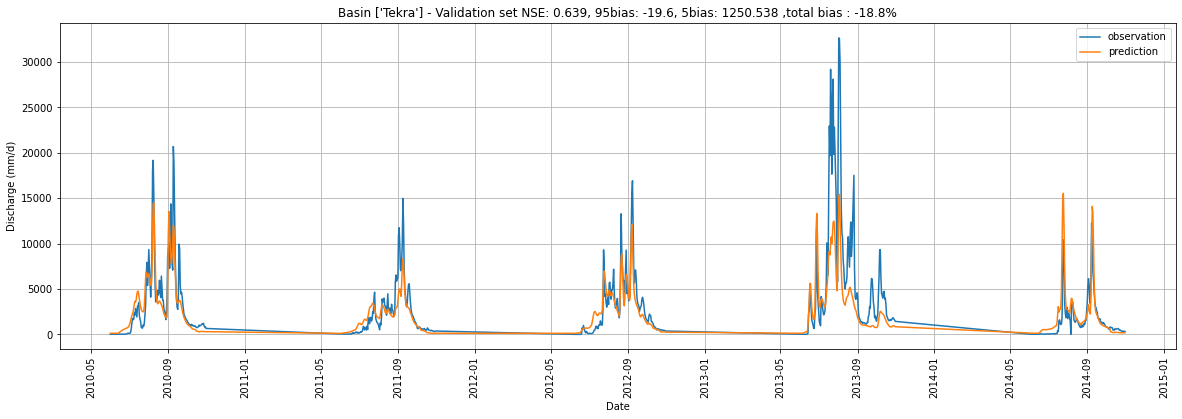

In [53]:
# Evaluate on test set
# Validation data. We use the feature means/stds of the training period for normalization
# Training data

# Use existing model
# CNNLSTM:
#path_to_ckpt = 'drive/MyDrive/RonenRojasEfratMorin/Code/cnn_lstm/2021_08_17-09-30-35/epoch_50_nse_0.798.ckpt'
#model = torch.load(path_to_ckpt)
# CNNLSTM monsoon
#path_to_ckpt = 'drive/MyDrive/RonenRojasEfratMorin/Code/cnn_lstm/2021_08_23-18-29-43/epoch_50_nse_0.588.ckpt'
#model = torch.load(path_to_ckpt)
# DNN:
#path_to_ckpt = 'drive/MyDrive/RonenRojasEfratMorin/Code/cnn_lstm/2021_08_19-15-36-05/epoch_50_nse_0.881.ckpt'
#model = torch.load(path_to_ckpt)


# start_date = (2000, 1, 1)
# end_date = (2014, 12, 31)
start_date = (2010, 1, 1)
end_date = (2014, 12, 31)
months_lst = [6,7,8,9,10]

Validation_basin = ["Tekra"]
#ds_val = IMDGodavari(all_data, basin_list=Validation_basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date], idx= idx_features, lead=lead, min_values=ds_train.get_min(), max_values=ds_train.get_max())
ds_val = IMDGodavari(all_data, basin_list=Validation_basin, seq_length=sequence_length, period="eval", 
                     dates=[start_date, end_date], months = months_lst, idx= idx_features, lead=lead, 
                     min_values=ds_train.get_min(), max_values=ds_train.get_max(), mean_y=ds_train.get_mean_y(), std_y=ds_train.get_std_y(),
                     include_static=INCLUDE_STATIC)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)
#path_to_ckpt = "drive/MyDrive/Efrat/cnn_lstm/2021_08_10-14-48-52/epoch_15_nse_0.774.ckpt"   
# path_to_ckpt = last_model_path   
# if path_to_ckpt:
#   # 'drive/MyDrive/Efrat/model_lstm/2021_07_24-21-23-40/epoch_6_nse_0.825.ckpt'
#   model = torch.load(path_to_ckpt)
obs, preds = eval_model(model, val_loader)
preds = ds_val.local_rescale(preds.cpu().numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)
pb95, pb5, total_b =  calc_bias(obs, preds)
# Plot results
start_date_tpl = ds_val.dates[0]
start_date = pd.to_datetime(datetime.datetime(start_date_tpl[0], start_date_tpl[1], start_date_tpl[2], 0, 0)) + pd.DateOffset(days=ds_val.seq_length + ds_val.lead)
end_date_tpl = ds_val.dates[1]
temp = pd.to_datetime(datetime.datetime(end_date_tpl[0], end_date_tpl[1], end_date_tpl[2], 0, 0))
end_date = temp + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)
#months = get_months_by_dates(start_date, end_date)
ind_include = [i for i in range(0,len(date_range)) if date_range[i].month in months_lst]
date_range = date_range[ind_include]
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(date_range, obs, label="observation")
ax.plot(date_range, preds, label="prediction")
ax.legend()
ax.set_title(f"Basin {Validation_basin} - Validation set NSE: {nse:.3f}, 95bias: {pb95:.1f}, 5bias: {pb5:.3f} ,total bias : {total_b: .1f}%")
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.set_xlabel("Date")
ax.grid('on')
_ = ax.set_ylabel("Discharge (mm/d)")

# Integrated gradients

In [ ]:
# Install package
!pip install captum
from captum.attr import IntegratedGradients

In [ ]:
# Calculate Integrated Gradients
# path_to_ckpt = last_model_path 
# path_to_ckpt = 'drive/MyDrive/RonenRojasEfratMorin/Code/cnn_lstm/2021_08_17-09-30-35/epoch_50_nse_0.798.ckpt'
# if path_to_ckpt:
#   model = torch.load(path_to_ckpt)

start_date_ig = (2012, 8, 26) 
end_date_ig = (2012, 9, 5)
# start_date_ig = (start_date.year,start_date.month,start_date.day) # the full validation period
# end_date_ig = (end_date.year,end_date.month,end_date.day) 
#new_date_range, idx =  get_date_range_and_idx(start_date_ig, end_date_ig, date_range)
# set model to eval mode (important for dropout)
model.eval()
model.cpu()
ig =  IntegratedGradients(model, multiply_by_inputs=True)
basline = torch.zeros(ds_val.x[idx[0]:idx[0]+1, : , : ].shape)
integ_grad = np.zeros(ds_val.x[idx[0]:idx[0]+1, : , : ].shape)
for i in idx:
  integ_grad += ig.attribute(ds_val.x[i:(i+1), : , : ], basline).numpy()
integ_grad = np.squeeze(integ_grad)
integ_grad /= len(idx) 
_ = model.cuda()

image_grad = integ_grad[:, :H_LAT*W_LON].reshape((sequence_length,H_LAT,W_LON))
time_vector_grad = np.sum(image_grad.reshape((image_grad.shape[0],image_grad.shape[1]*image_grad.shape[2])),axis=1)
spatial_image_grad= np.sum(image_grad,axis=0)
atrrib_grade = integ_grad[:, H_LAT*W_LON:]


In [ ]:
# Calculate Integrated Gradients by quantile

# path_to_ckpt = last_model_path 
# path_to_ckpt = 'drive/MyDrive/RonenRojasEfratMorin/Code/cnn_lstm/2021_08_17-09-30-35/epoch_50_nse_0.798.ckpt'
# if path_to_ckpt:
#   model = torch.load(path_to_ckpt)

predsmonsoon = preds[np.where((date_range.month>=6) & (date_range.month<=10))[0]]
obsmonsoon = obs[np.where((date_range.month>=6) & (date_range.month<=10))[0]]
threshq1 = np.percentile(predsmonsoon,90)
threshq2 = np.percentile(predsmonsoon,55)
#idx = np.asarray([i for i in range(0,len(preds)) if (preds[i]>threshq1) & (preds[i]<threshq2)])
idx = np.asarray([i for i in range(0,len(preds)) if (preds[i]>threshq1)])
#idx = np.where((preds>threshq1) & (preds<threshq2) & (date_range.month>=6) & (date_range.month<=10))[0]
print([threshq1,threshq2,idx.shape])
# set model to eval mode (important for dropout)
model.eval()
model.cpu()
ig =  IntegratedGradients(model, multiply_by_inputs=True)
basline = torch.zeros(ds_val.x[idx[0]:idx[0]+1, : , : ].shape)
integ_grad = np.zeros(ds_val.x[idx[0]:idx[0]+1, : , : ].shape)
for i in idx:
  #print (i)
  integ_grad += ig.attribute(ds_val.x[i:(i+1), : , : ], basline).numpy()
integ_grad = np.squeeze(integ_grad)
integ_grad /= len(idx) 
_ = model.cuda()

image_grad = integ_grad[:, :H_LAT*W_LON].reshape((sequence_length,H_LAT,W_LON))
time_vector_grad = np.sum(image_grad.reshape((image_grad.shape[0],image_grad.shape[1]*image_grad.shape[2])),axis=1)
spatial_image_grad= np.sum(image_grad,axis=0)
atrrib_grade = integ_grad[:, H_LAT*W_LON:]


[8001.339746093759, 3011.47900390625, (77,)]


In [ ]:
#integ_file = PATH_ROOT + "Out/integ_grad_2000_2014" 
#np.save(file=integ_file, arr=integ_grad)

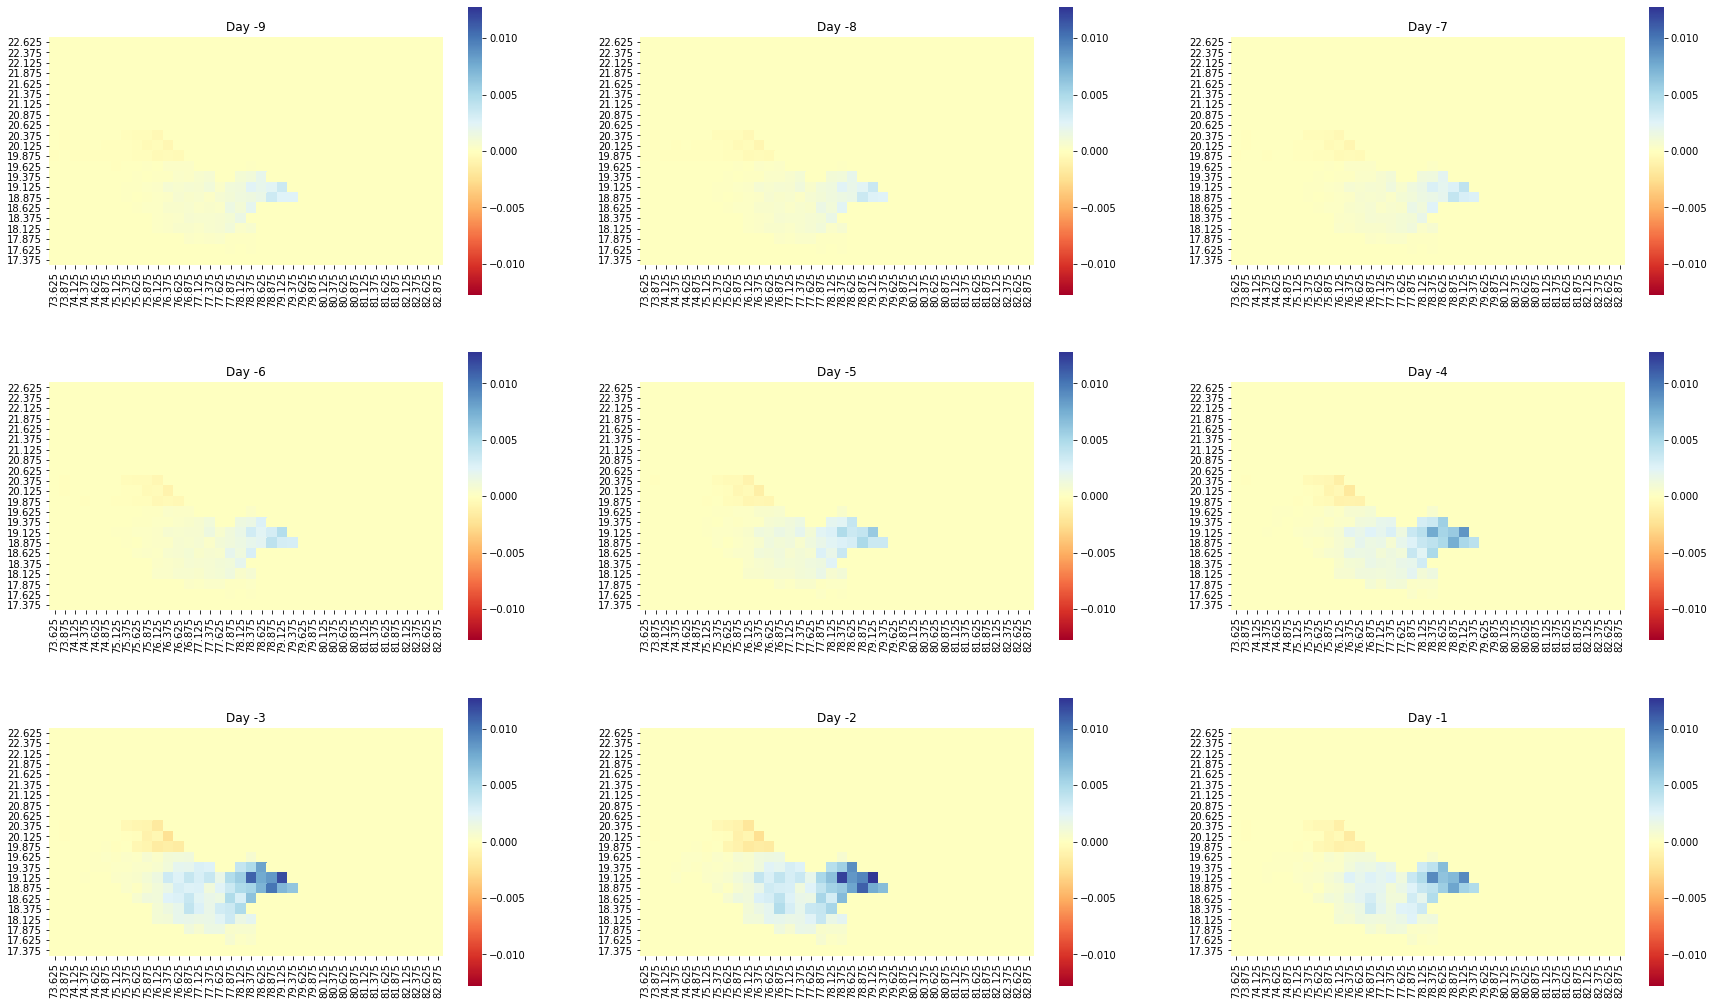

In [ ]:
# Plot Integrated Gradients - Spatial 
sequence_length_small = 9
image_grad_small = image_grad[sequence_length-sequence_length_small:,:]
n_w_win = 3
n_h_win = int((sequence_length_small+1)/n_w_win)
fig, ax = plt.subplots(n_h_win, n_w_win, figsize=(10*n_h_win,6*n_w_win))
max_v = abs(image_grad_small).max()
min_v = -max_v
for i in range(sequence_length_small):
  ax.flat[i].set_title(f'Day {i-sequence_length_small}')
  df = pd.DataFrame(image_grad_small[i,:], index =list(LAT_GRID), columns =list(LON_GRID))  
  sns.heatmap(df[::-1], ax=ax.flat[i], vmin= min_v, vmax= max_v,square=True,cmap='RdYlBu')



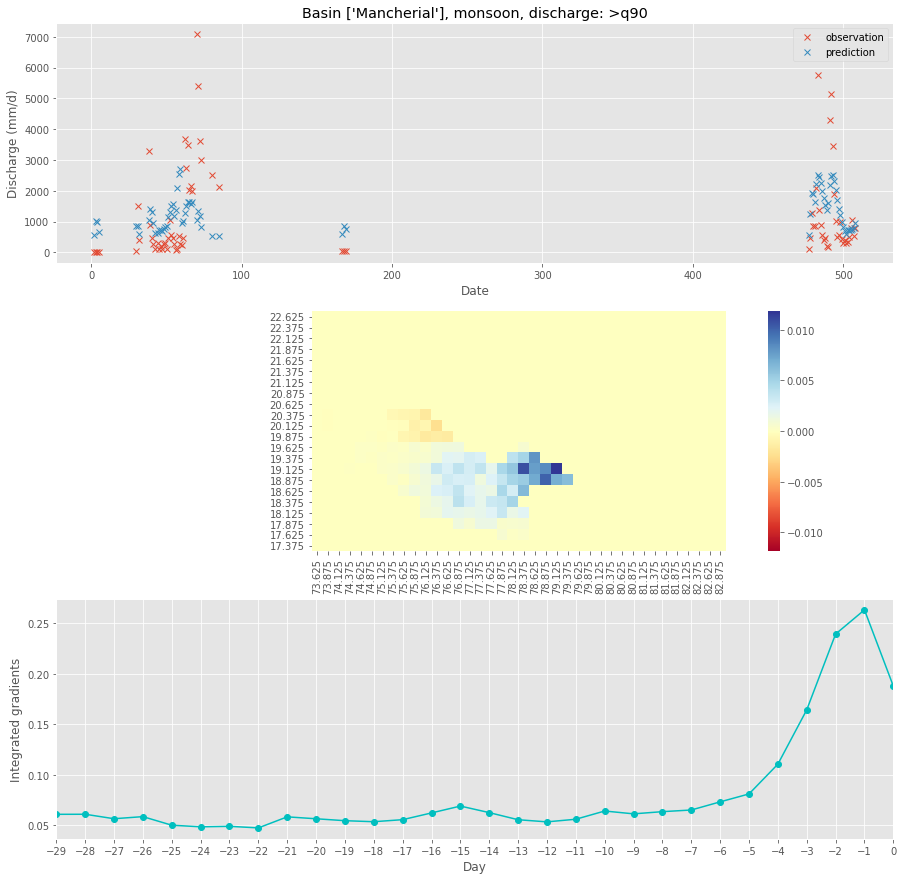

In [ ]:
# plot without catchment attributes
with plt.style.context('ggplot'):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
  # ax1.plot(new_date_range, obs[idx], label="observation")
  # ax1.plot(new_date_range, preds[idx], label="prediction")
  #ax1.plot(idx, obs[idx], 'x', label="observation")
  #ax1.plot(idx, preds[idx],'x', label="prediction")
  ax1.plot(idx, obs[idx], 'x', label="observation")
  ax1.plot(idx, preds[idx],'x', label="prediction")
  ax1.legend()
#  ax1.set_title(f"Basin {Validation_basin} discharge>q95")
  ax1.set_title(f"Basin {Validation_basin}, monsoon, discharge: >q90")
  #ax1.xaxis.set_tick_params(rotation=90)
  ax1.set_xlabel("Date")
  ax1.grid('on')
  _ = ax1.set_ylabel("Discharge (mm/d)")

#  df = pd.DataFrame(spatial_image_grad, index =list(LAT_GRID), columns =list(LON_GRID))
  df = pd.DataFrame(image_grad_small[sequence_length_small-3,:], index =list(LAT_GRID), columns =list(LON_GRID))
#  vmax=np.max(np.abs(spatial_image_grad.flat))  
  vmax=np.max(np.abs(image_grad_small[sequence_length_small-3,:].flat))  
  sns.heatmap(df[::-1], ax=ax2,square=True,cmap='RdYlBu',vmin=-vmax,vmax=vmax)

  txn = np.arange(-sequence_length+1,0+1)
  ax3.plot(txn,time_vector_grad,'-o',color='c')
  ax3.set_xlabel("Day")
  ax3.set_ylabel("Integrated gradients")
  ax3.set_xlim([-sequence_length+1,0])
  ax3.set_xticks(txn)



In [ ]:
# plot 
with plt.style.context('ggplot'):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
  ax1.plot(new_date_range, obs[idx], label="observation")
  ax1.plot(new_date_range, preds[idx], label="prediction")
  ax1.legend()
  ax1.set_title(f"Basin {Validation_basin}")
  #ax1.xaxis.set_tick_params(rotation=90)
  ax1.set_xlabel("Date")
  ax1.grid('on')
  _ = ax1.set_ylabel("Discharge (mm/d)")

  ax2.bar(['Precipitation',"Mean Precipitation","Aridity","Area","Mean elevation"],sum(att),color=['b','g','g','g','g'])
  ax2.plot(['Precipitation',"Mean Precipitation","Aridity","Area","Mean elevation"],[0,0,0,0,0],'k')
  ax2.set_ylabel("Attribute sum integrated gradients")

  txn = np.arange(-sequence_length+1,0+1)
  ax3.plot(txn,att[:,0],'-o',color='c')
  ax3.set_xlabel("Day")
  ax3.set_ylabel("Integrated gradients")
  ax3.set_xlim([-sequence_length+1,0])
  ax3.set_xticks(txn)

In [ ]:
## This cell is for creating the raw data - no need to run this 
start_date_pd = pd.to_datetime(datetime.datetime(DATA_START_DATE[0], DATA_START_DATE[1], DATA_START_DATE[2], 0, 0))
end_date_pd = pd.to_datetime(datetime.datetime(DATA_END_DATE[0], DATA_END_DATE[1], DATA_END_DATE[2], 0, 0))
date_range = pd.date_range(start_date_pd, end_date_pd)
num_days = len(date_range)
num_features = 3
h = len(LAT_GRID)
w = len(LON_GRID)
data = np.zeros((num_days, num_features , h, w))
for i, lat_i in enumerate(LAT_GRID):
  for j, lon_j in enumerate(LON_GRID):  
    x = get_geo_raw_data(lat_i, lon_j, start_date, end_date)
    data[:,:, i, j] = x
out_path = PATH_ROOT + 'Data/'
data.tofile(out_path+ "raw_data_fixed" + '_'.join([str(_) for _ in data.shape]))